In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams['font.family'] = 'Malgun Gothic'
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [66]:
# Try loading the CSV data with 'CP949' encoding (common for Korean text)
csv_data = pd.read_csv(r"C:/Users/82107/Desktop/pairtrading/Train_Data.csv", encoding='CP949')

csv_data.columns = csv_data.iloc[0]
csv_data.index = csv_data.iloc[:,0]
csv_data = csv_data.iloc[1:,1:]
csv_data.head()

,삼성전자,SK하이닉스,LG에너지솔루션,삼성바이오로직스,현대차,기아,셀트리온,POSCO홀딩스,KB금융,NAVER,...,코리아오토글라스,경남은행,광주은행,엔에이치스팩19호,에이치디현대마린솔루션,연합과기,중국원양자원,평산차업 KDR,중국고섬,SBI모기지
Symbol Name,,,,,,,,,,,,,,,,,,,,,
2004-04-01,"11,500","12,450",NaN,NaN,"52,000","11,850",NaN,"160,500",NaN,"9,094",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-02,"11,300","12,550",NaN,NaN,"51,900","11,700",NaN,"165,000",NaN,"9,436",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-06,"11,900","13,750",NaN,NaN,"53,300","11,950",NaN,"165,000",NaN,"9,671",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-07,"12,000","13,750",NaN,NaN,"54,900","12,300",NaN,"168,500",NaN,"9,842",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-08,"12,100","13,500",NaN,NaN,"55,500","12,350",NaN,"175,500",NaN,"9,724",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
df = csv_data[['사조대림', '사조산업', '사조오양', '한성기업', '동원수산']]
df = df.dropna(axis=1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col].str.replace(',', ''))
df

,사조대림,사조산업,사조오양,한성기업,동원수산
Symbol Name,,,,,
2004-04-01,46560,4110,6309,2840,4850
2004-04-02,42890,3995,6150,2740,4700
2004-04-06,42661,3930,5769,2610,4430
2004-04-07,48853,4515,6634,3000,5090
2004-04-08,55963,5050,7619,3340,5770
...,...,...,...,...,...
2019-03-25,20600,52500,8910,5690,8540
2019-03-26,20850,53800,8890,5620,8540
2019-03-27,21400,54500,8900,5620,8500


In [68]:

def engle_granger_test(cols):
    y1 = df[cols[0]]
    y2 = df[cols[1]]
    model = OLS(y1,y2).fit()  
    residuals = model.resid  

    adf_test = adfuller(residuals)  
    adf_statistic = adf_test[0]
    critical_values = adf_test[4]
    p_value = adf_test[1]
    result = {
        'columns': cols,
        'adf_statistic': adf_test[0],  # ADF 통계량
        'p_value': adf_test[1],  # p-값
        'critical_values': adf_test[4],  # 임계값
    }
    return result

def get_pair(df):
    import itertools
    all_combinations  = list(itertools.combinations(df.columns, 2))

    results = []  # 결과를 저장할 리스트
    for combination in all_combinations:
        result = engle_granger_test(list(combination))
        results.append(result)

    results_sorted = sorted(results, key=lambda x: x['p_value']) 
    return results_sorted

results_sorted = get_pair(df)

In [79]:
def asset_selection(sets):    
    first_pair = sets[0]['columns']  # 가장 연관성이 큰 첫 번째 쌍
    asset1 = set()  # 첫 번째 그룹
    asset2 = set()  # 두 번째 그룹

    asset1.add(first_pair[0])  # 첫 번째 요소를 asset1에 추가
    asset2.add(first_pair[1])  # 두 번째 요소를 asset2에 추가

    # 나머지 쌍을 그룹에 배치
    for pair in sets[1:]:
        a, b = pair['columns']

        if a in asset1 and b in asset2:
            continue  # 이미 다른 그룹에 배치된 경우 건너뜀
        elif a in asset2 and b in asset1:
            continue  # 이미 다른 그룹에 배치된 경우 건너뜀
        elif a in asset1 and b not in asset1:
            asset2.add(b)  # a가 asset1에 있으면 b를 asset2에 배치
        elif a in asset2 and b not in asset2:
            asset1.add(b)  # a가 asset2에 있으면 b를 asset1에 배치
        elif b in asset1 and a not in asset1:
            asset2.add(a)  # b가 asset1에 있으면 a를 asset2에 배치
        elif b in asset2 and a not in asset2:
            asset1.add(a)  # b가 asset2에 있으면 a를 asset1에 배치
        elif (a not in asset1 and b not in asset2) or (b not in asset1 and a not in asset2):
            # a, b 모두 기존 그룹에 속하지 않은 경우 서로 다른 그룹에 배치
            asset1.add(a)
            asset2.add(b)
        else:
            sets.pop()
            continue

    # 결과 출력
    print("Asset 1:", list(asset1))  # 첫 번째 그룹의 요소
    print("Asset 2:", list(asset2))  # 두 번째 그룹의 요소
    return asset1, asset2

def select_result(results_sorted):
    selected_results = [
        result for result in results_sorted 
        if result['adf_statistic'] < result['critical_values']['5%']
    ]
    selected_results
    asset1, asset2 = asset_selection(selected_results)
    selected_results
    for result in selected_results:
        asset1_name, asset2_name = result['columns']
        if asset1_name not in asset1 or asset2_name not in asset2:
            # 두 자산의 순서가 리스트 순서와 일치하지 않는 경우, 순서를 바꿉니다.
            result['columns'] = [asset1_name, asset2_name]
    return selected_results, asset1, asset2

selected_results, asset1, asset2 = select_result(results_sorted)
selected_results

Asset 1: ['사조대림']
Asset 2: ['한성기업', '사조오양', '사조산업', '동원수산']


[{'columns': ['사조대림', '한성기업'],
  'adf_statistic': -5.426572845284566,
  'p_value': 2.9780317093970385e-06,
  'critical_values': {'1%': -3.4321243647935256,
   '5%': -2.8623240159955396,
   '10%': -2.5671873431831442},
  'ratio': 0.6452932498278299},
 {'columns': ['사조대림', '사조오양'],
  'adf_statistic': -5.28440592459994,
  'p_value': 5.897959576991717e-06,
  'critical_values': {'1%': -3.4321258103320154,
   '5%': -2.8623246545267254,
   '10%': -2.5671876831152},
  'ratio': 0.32582518322842025},
 {'columns': ['사조대림', '동원수산'],
  'adf_statistic': -4.716133521866583,
  'p_value': 7.847221995144626e-05,
  'critical_values': {'1%': -3.432125328224223,
   '5%': -2.862324441567463,
   '10%': -2.5671875697430027},
  'ratio': 0.024488968975723807},
 {'columns': ['사조대림', '사조산업'],
  'adf_statistic': -4.303824493498182,
  'p_value': 0.0004374868298522349,
  'critical_values': {'1%': -3.432128224803953,
   '5%': -2.8623257210598148,
   '10%': -2.567188250900874},
  'ratio': 0.00439259796802618}]

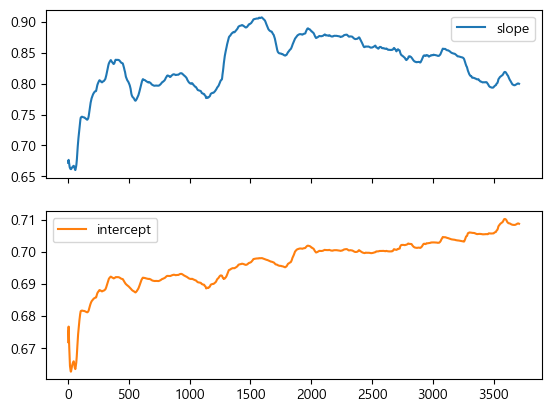

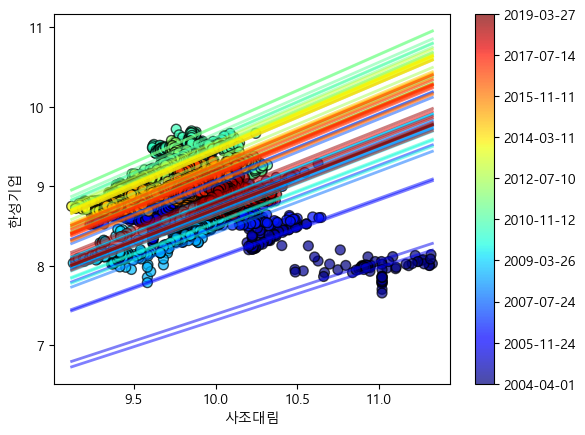

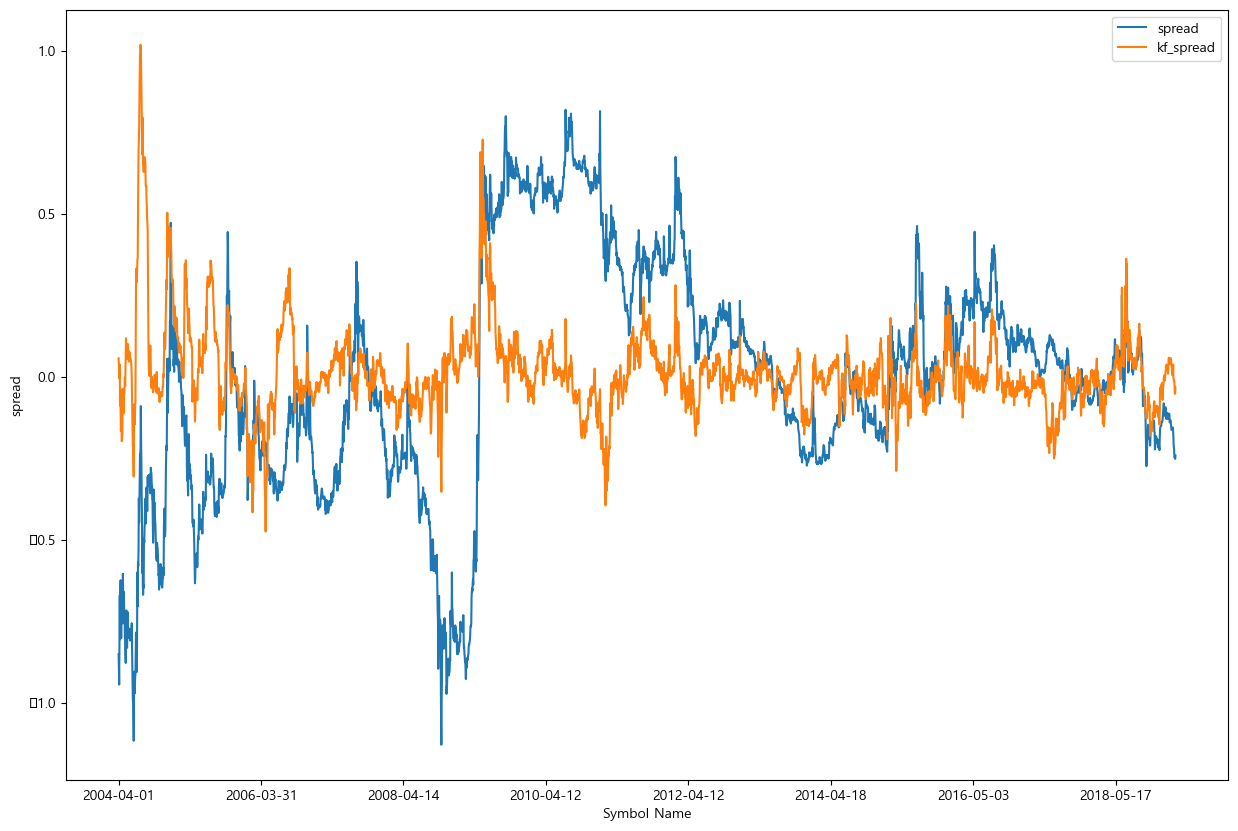

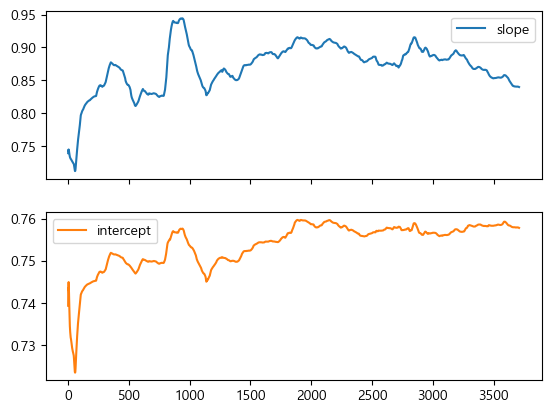

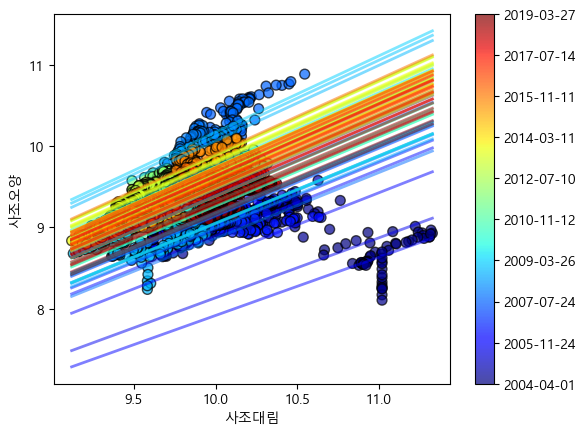

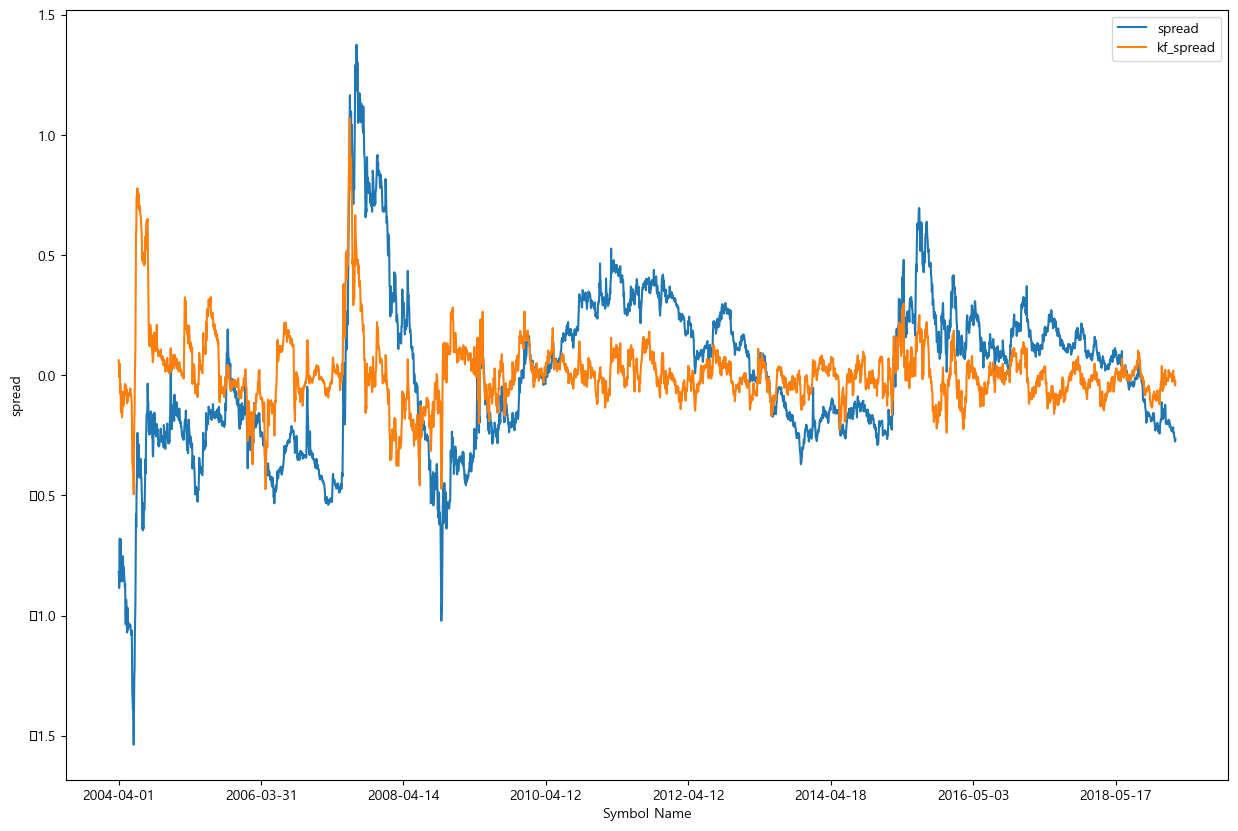

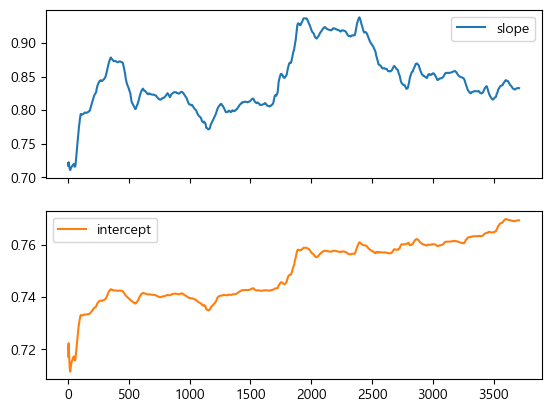

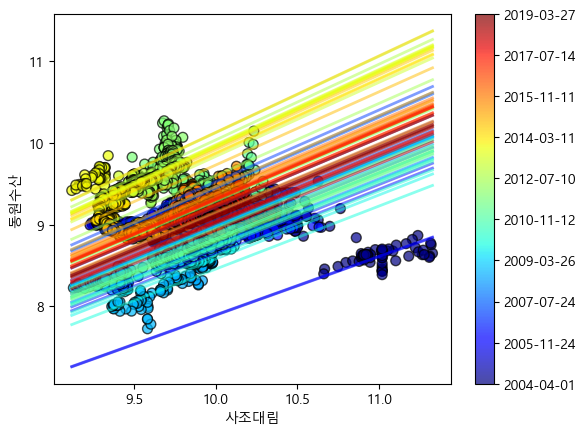

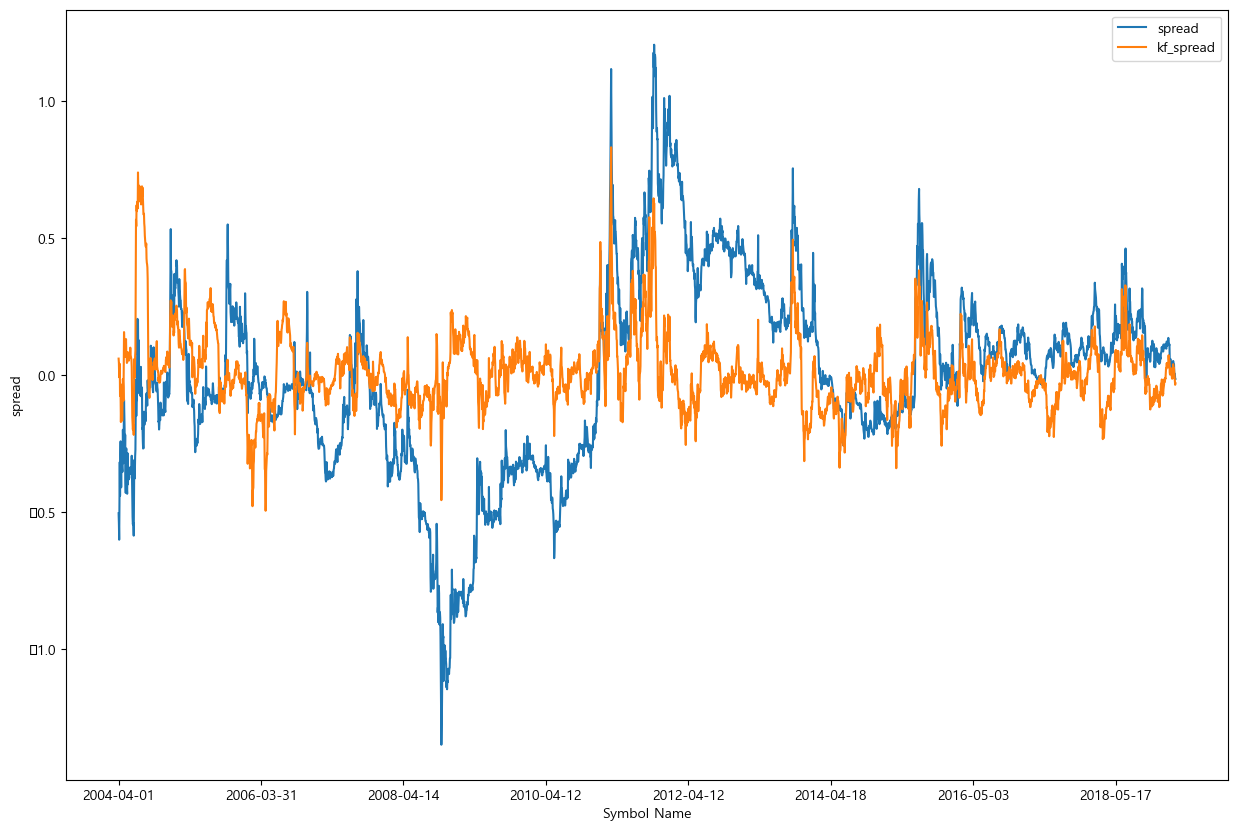

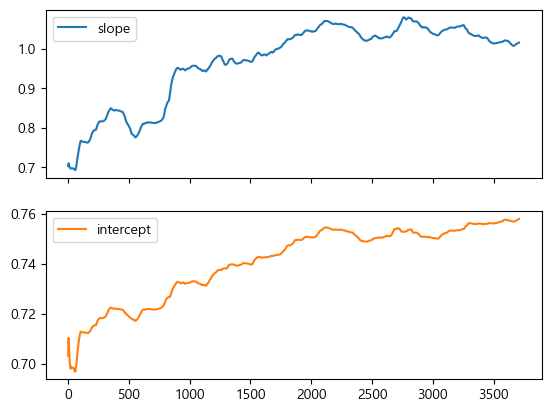

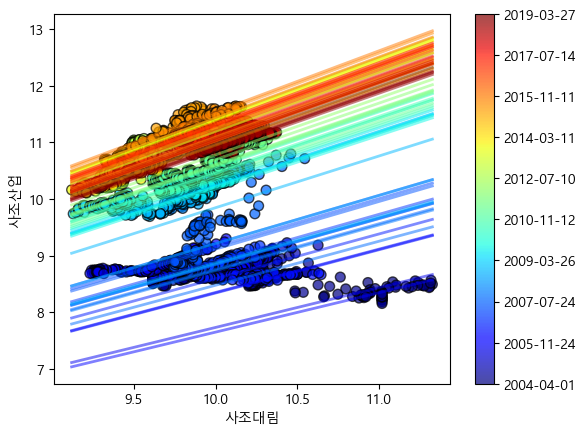

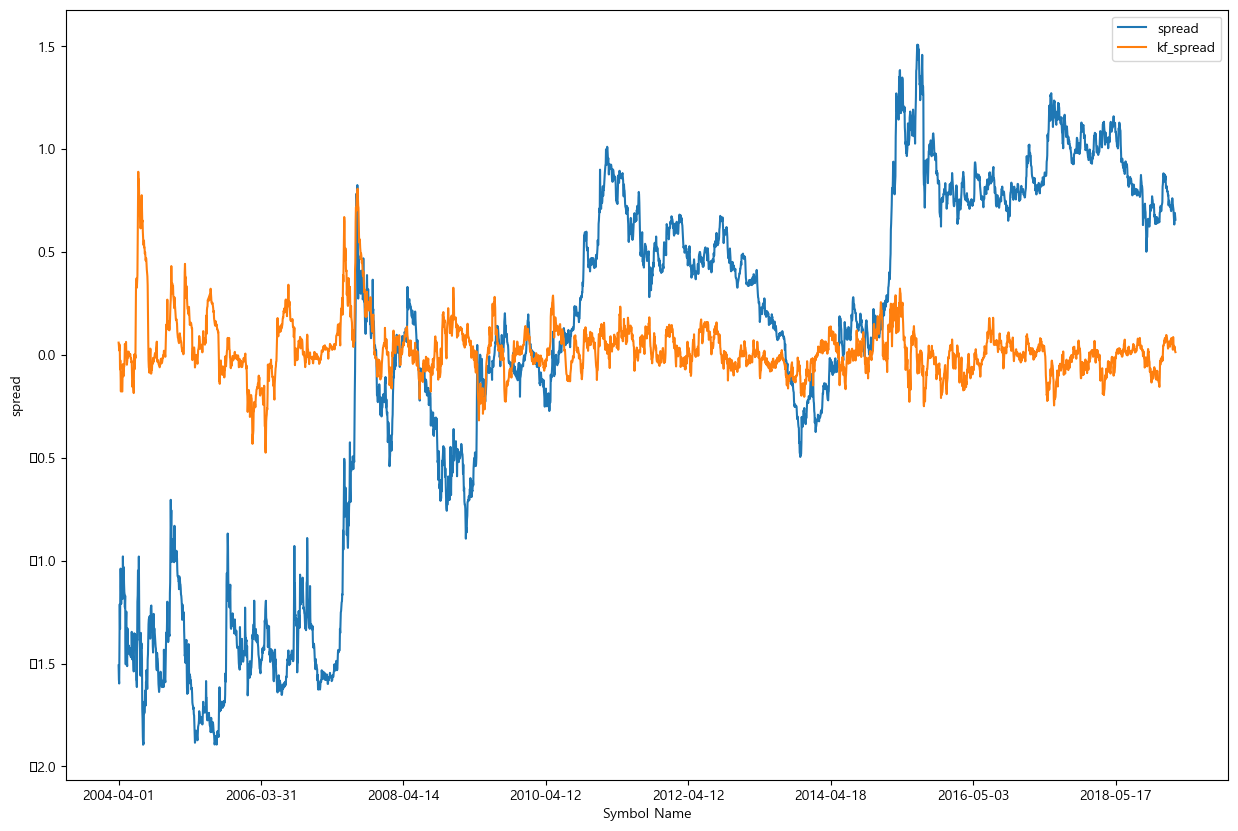

In [70]:
def kalman_graph(selected_results, df):
    stat_all = []; spread_all=[]
    for i in range(len(selected_results)):
        tickers = selected_results[i]['columns']
        obs_mat = sm.add_constant(np.log(df[tickers[0]].values), prepend=False)[:, np.newaxis]
        delta = 1e-5
        trans_cov = delta / (1 - delta) * np.eye(2)

        # y is 1-dimensional, (alpha, beta) is 2-dimensional
        kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                        initial_state_mean=np.zeros(2),
                        initial_state_covariance=np.ones((2, 2)),
                        transition_matrices=np.eye(2),
                        observation_matrices=obs_mat,
                        observation_covariance=1.0,
                        transition_covariance=trans_cov)

        state_means, state_covs = kf.filter(np.log(df[tickers[1]]))
        beta_kf = pd.DataFrame(state_means, columns=['slope', 'intercept'])  # 회귀 계수 저장
        beta_kf.plot(subplots=True) 
        plt.show()

        # visualize the correlation between assest prices over time
        dates = [p for p in df[::int(len(df)/10)].index] # str(p.date())
        colors = np.linspace(0.1, 1, len(df))
        sc = plt.scatter(np.log(df[tickers[0]]), np.log(df[tickers[1]]),
                        s=50, c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
        cb = plt.colorbar(sc)
        cb.ax.set_yticklabels([p for p in df[::len(df)//9].index]); # [str(p.date())
        plt.xlabel(tickers[0])
        plt.ylabel(tickers[1])

        # add regression lines
        step = 50
        xi = np.linspace(np.log(df[tickers[0]].min()), np.log(df[tickers[0]].max()), 2)
        colors_l = np.linspace(0.1, 1, len(state_means[::step]))
        for i, b in enumerate(state_means[::step]):
            plt.plot(xi, b[0] * xi + b[1], alpha=.5, lw=2, c=plt.get_cmap('jet')(colors_l[i]))
        plt.show()

        x = list(np.log(df[tickers[0]]))
        x_const = sm.add_constant(x)
        y = list(np.log(df[tickers[1]]))
        linear_reg = sm.OLS(y,x_const)
        results = linear_reg.fit()
        beta = results.params[1]
        alpha = results.params[0]
        y_pred = np.log(df[tickers[0]])*beta + alpha

        df2 = pd.DataFrame(np.log(df[tickers[1]]) - np.log(df[tickers[0]])*beta-alpha,index=df[tickers[0]].index)
        df2.columns = ['spread']
        df2.plot(figsize =(15,10))   


        beta_kf.index = df.index
        spread_kf = np.log(df[tickers[1]]) - np.log(df[tickers[0]]) * beta_kf['slope'] - beta_kf['intercept']
        spread_all.append([spread_kf])
        spread_kf.plot(label = 'kf_spread')
        
        stat_all.append([tickers,state_means,state_covs])

        plt.ylabel('spread') 
        plt.legend()
        plt.show()
        
    return stat_all, spread_all

stat_all, spread_all = kalman_graph(selected_results, df)

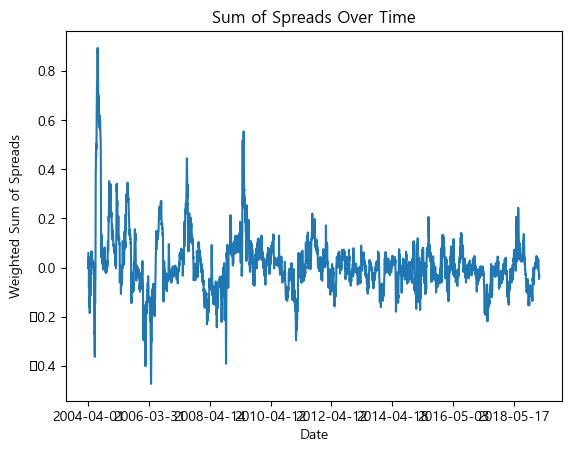

In [71]:
def get_spread(selected_results, spread_all):
    total_inverse_p_value = sum(1 / item['p_value'] for item in selected_results)
    for item in selected_results:
        item['ratio'] = (1 / item['p_value']) / total_inverse_p_value
    ratios = np.array([item['ratio'] for item in selected_results])  # 이제 numpy 배열로 변환하여 문제 해결 시도
    spread_series = [pd.Series(spread) for spread in spread_all]
    weighted_spreads = [spread_series[i][0] * ratios[i] for i in range(len(spread_series))]
    weighted_sum_spreads = pd.concat(weighted_spreads, axis=1).sum(axis=1)
    weighted_sum_spreads_series = pd.Series(weighted_sum_spreads)
    weighted_sum_spreads_series.plot()
    plt.title('Sum of Spreads Over Time')
    plt.xlabel('Date')
    plt.ylabel('Weighted Sum of Spreads')
    plt.show()
    return weighted_sum_spreads_series
weighted_sum_spreads_series = get_spread(selected_results, spread_all)

In [72]:
def adftest(data):
    #adf 검정!
    result = adfuller(data)

    print('정상성이 있는지 판단 : ')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return key

def ARIMA_model(data):
    #델타yt의 경우와 그냥 yt의 경우에 감마의 값에 따라 평균회귀 가능성이 어떻게 달라지는지 조심하세요
    model = ARIMA(data, order=(1, 0, 0))
    model_fit = model.fit()
    print(f'λ 값의 유도(델타yt가 아닌 그냥 yt임 주의!!) : { model_fit.params[1] }')
    half = -np.log(2)/(model_fit.params[1]-1)
    print(f'반감기 : {half}')

    display(model_fit.summary())
    return half

def RS_func(data):
    L = np.log10(data[1:].values / data[:-1].values)
    nan_inf_indices = np.isnan(L) | np.isinf(L)
    L = L[~nan_inf_indices]
    Z = np.mean(L)
    C = np.cumsum(L-Z)
    R = max(C) - min(C)
    S = np.std(L)
    return R/S

def hurst_func(data):
    min_window = 10
    max_window = len(data) - 1
    by_factor = np.log10(2.0)
    window_sizes = list(map(lambda x: int(10 ** x),np.arange(np.log10(min_window), np.log10(max_window), by_factor)))
    window_sizes.append(len(data))

    RS = []
    for w in window_sizes:
        rs = []
        for start in range(0, len(data), w):
            if (start + w) > len(data):
                break
            res = RS_func(data[start:start + w].astype(np.float64))
            if res != 0:
                rs.append(res)
        RS.append(np.mean(rs))

    lm1 = LinearRegression().fit(np.log10(window_sizes).reshape(-1, 1),np.log10(RS).reshape(-1, 1))
    hurst_exp = lm1.coef_[0][0]
    print(f'H = {hurst_exp}')
    return hurst_exp
key = adftest(weighted_sum_spreads_series)
half=ARIMA_model(weighted_sum_spreads_series)
H = hurst_func(weighted_sum_spreads_series)

정상성이 있는지 판단 : 
ADF Statistic: -7.727152
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
λ 값의 유도(델타yt가 아닌 그냥 yt임 주의!!) : 0.970096297903149
반감기 : 23.17930998359353


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3711
Model:                 ARIMA(1, 0, 0)   Log Likelihood                7914.603
Date:                Fri, 03 May 2024   AIC                         -15823.207
Time:                        02:51:47   BIC                         -15804.549
Sample:                             0   HQIC                        -15816.568
                               - 3711                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0111      0.016      0.695      0.487      -0.020       0.042
ar.L1          0.9701      0.002    402.138      0.000       0.965       0.975
sigma2         0.0008   9.26e-06     88.727      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   9.17   Jarque-Bera (JB):              6767.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

H = 0.42605053462885073


In [73]:
mean_spread = weighted_sum_spreads_series.mean()
std_spread = weighted_sum_spreads_series.std()
upper_bound = mean_spread + 2 * std_spread
upper_stop_bound = mean_spread + 3 * std_spread
lower_bound = mean_spread - 2 * std_spread
lowwer_stop_bound = mean_spread - 3 * std_spread
close_range = std_spread * 0.1
print(upper_bound,upper_stop_bound,lower_bound,lowwer_stop_bound)

0.24737714313229558 0.3655048035978065 -0.22513349872974808 -0.34326115919525896


In [74]:
csv_data = pd.read_csv(r"C:/Users/82107/Desktop/pairtrading/Test_Data.csv", encoding='CP949')
csv_data.columns = csv_data.iloc[0]
csv_data.index = csv_data.iloc[:,0]
csv_data = csv_data.iloc[1:,1:]
df = csv_data[['사조대림', '사조산업', '사조오양', '한성기업', '동원수산']]
df = df.dropna(axis=1)
for col in df.columns:
    df[col] = pd.to_numeric(df[col].str.replace(',', ''))
df

,사조대림,사조산업,사조오양,한성기업,동원수산
Symbol Name,,,,,
2019-04-01,21250,53100,8900,5650,8530
2019-04-02,21600,53000,8850,5640,8510
2019-04-03,21700,53500,8810,5680,8580
2019-04-04,21650,54800,8830,5730,8590
2019-04-05,21750,54700,8940,5760,8600
...,...,...,...,...,...
2024-03-25,35500,38600,8660,5790,6750
2024-03-26,36350,38650,8650,5620,6810
2024-03-27,35550,38550,8690,5610,6730


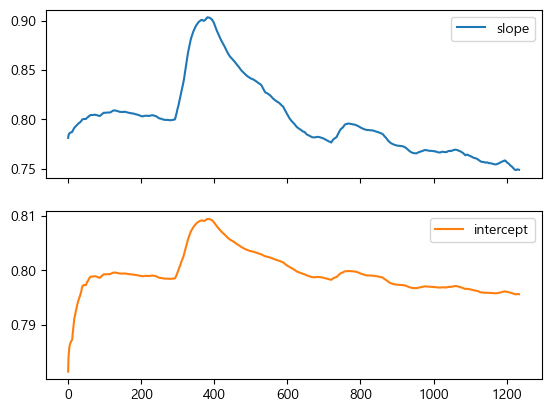

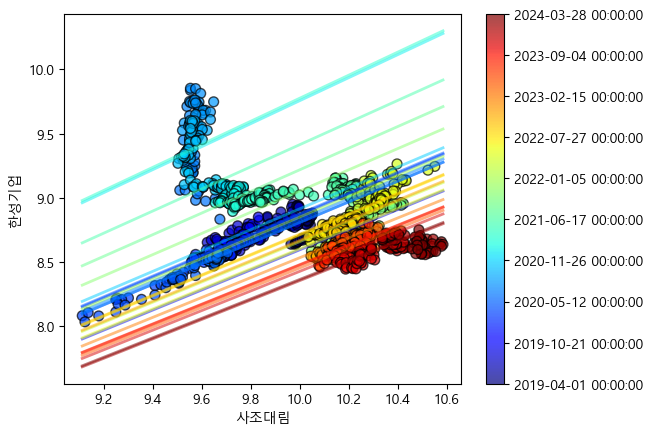

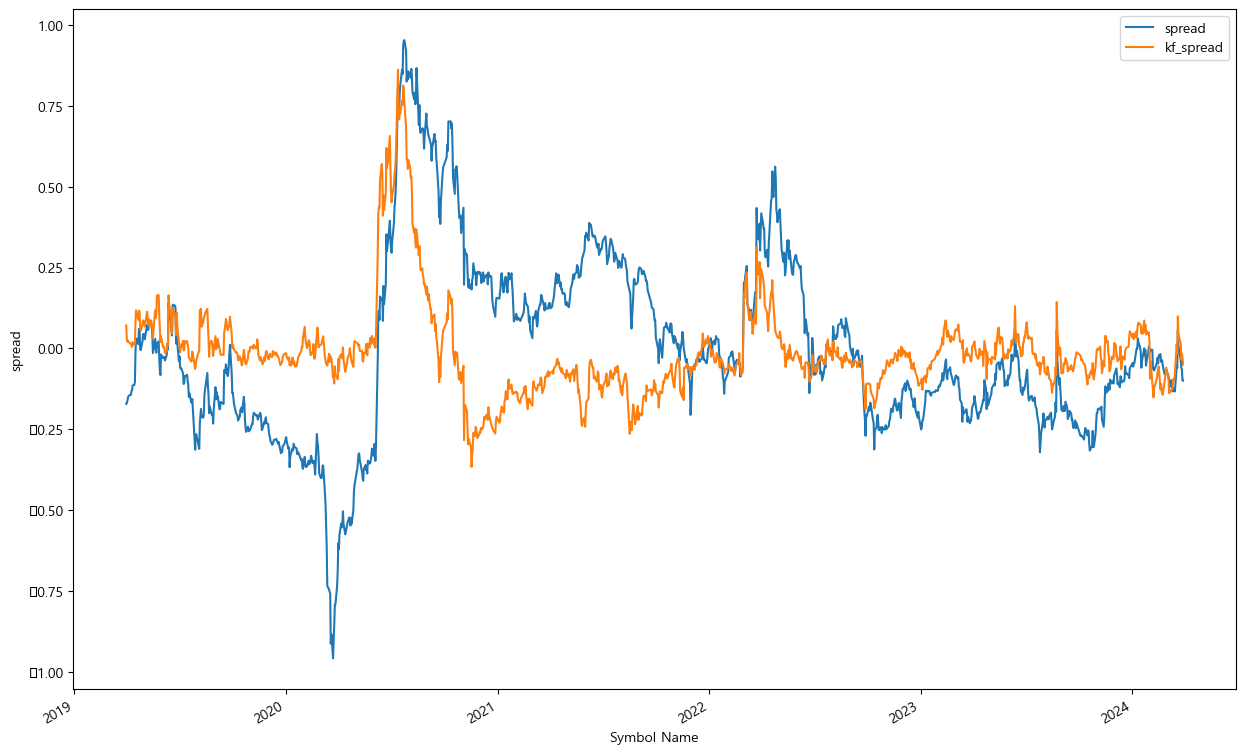

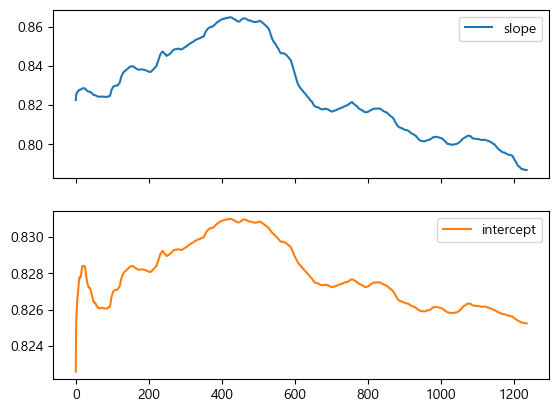

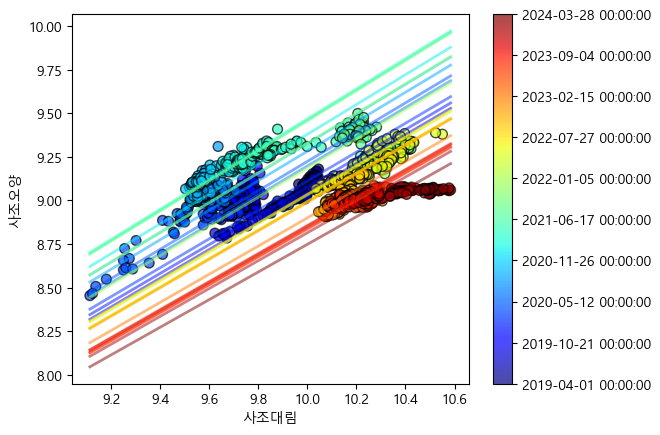

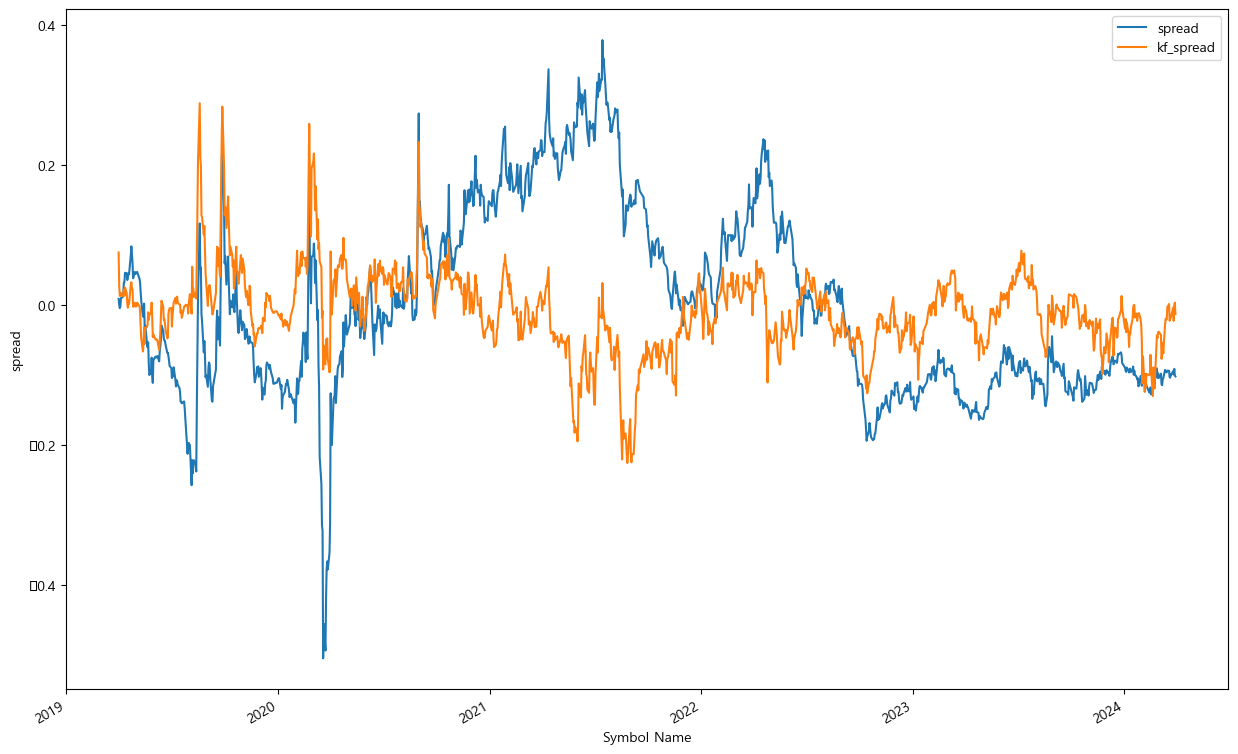

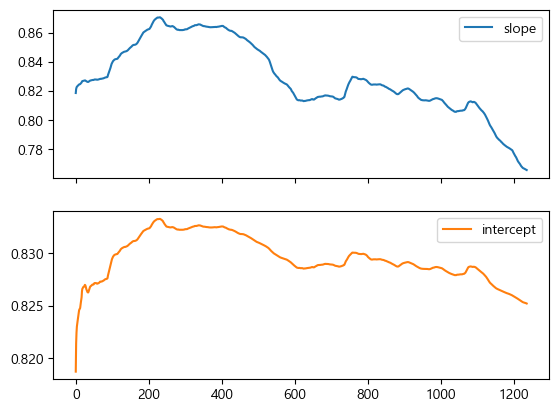

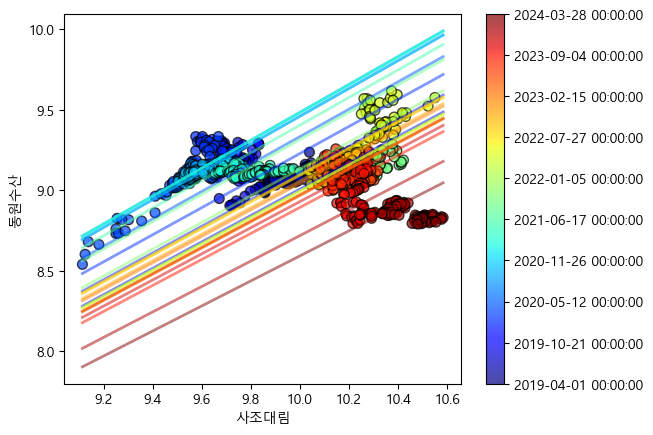

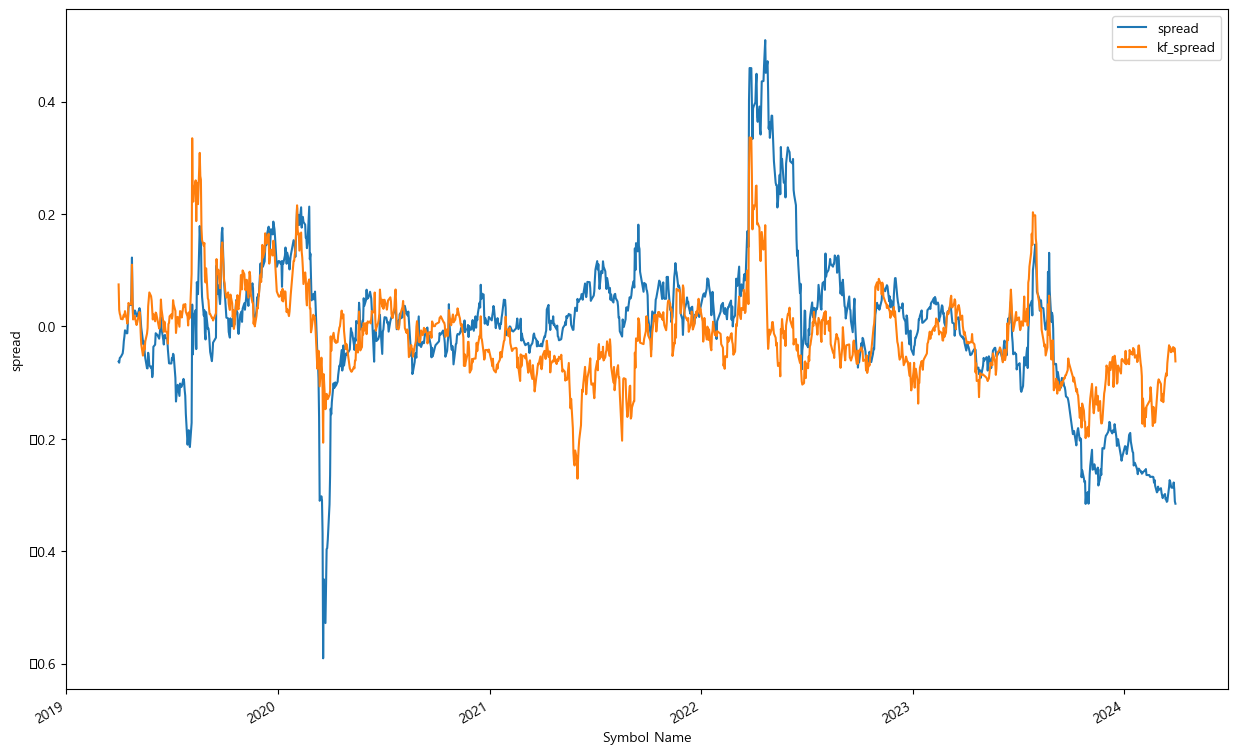

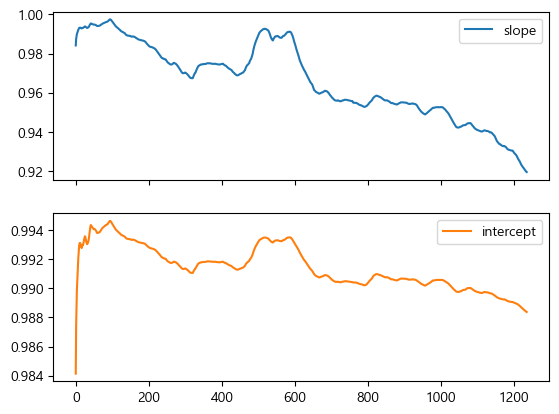

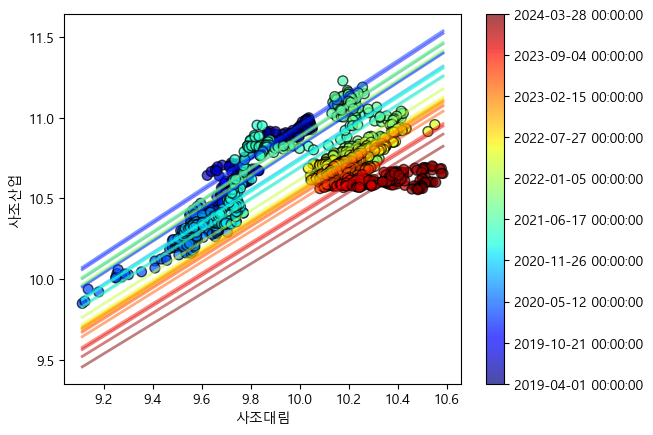

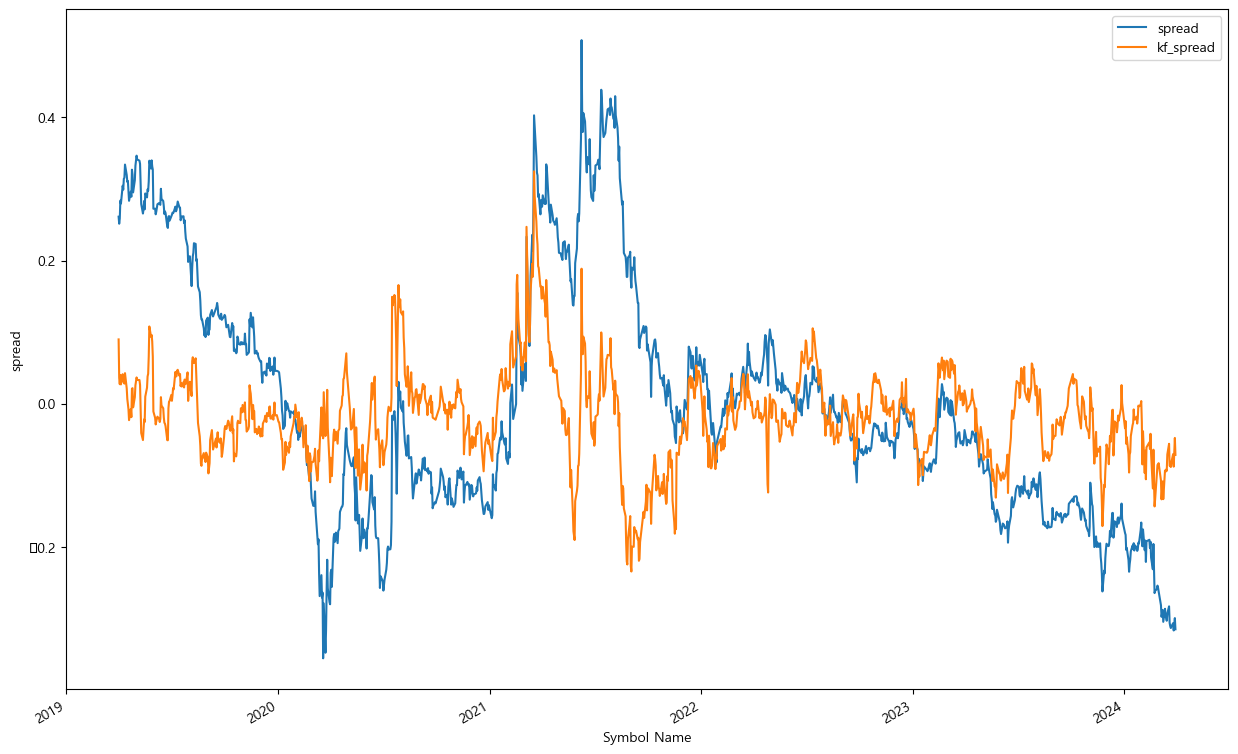

In [258]:
stat_all, spread_all = kalman_graph(selected_results, df)

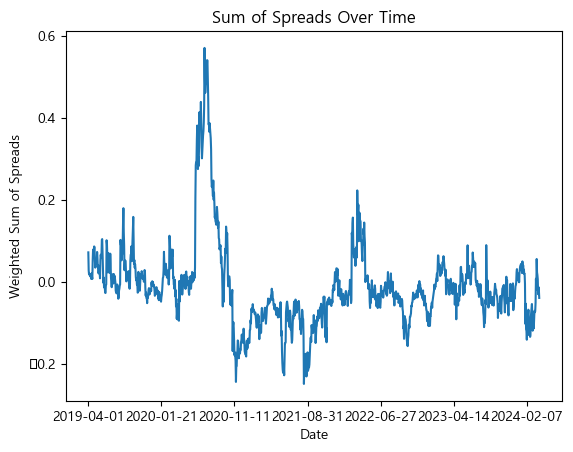

In [116]:
weighted_sum_spreads_series = get_spread(selected_results, spread_all)

매매 방식 : 1. 스프레드 2표준편차 2연속 진입시 매매, 2. traindata 3표준편차 진입시 손절 3. ouprocess하에 반감기 기준 보유기간

In [118]:
# 상태 플래그
def get_signal(weighted_sum_spreads_series,mean_spread, close_range, upper_stop_bound, lowwer_stop_bound,half):
    above = False
    below = False
    keep = False
    signals = []
    startday=0

    for date, value in weighted_sum_spreads_series.items():
        day = weighted_sum_spreads_series.index.get_loc(date)
        if value > upper_bound:
            above = True
        elif value < lower_bound:
            below = True
        elif keep and ((mean_spread - close_range <= value <= mean_spread + close_range) or value > upper_stop_bound or value < lowwer_stop_bound or day - startday > half):
            for index, result in enumerate(selected_results):
                asset1_name = result['columns'][0]
                asset2_name = result['columns'][1]
                if asset1_name in asset1 and asset2_name in asset2:
                    signals.append({
                        'Date': date,
                        'asset1': asset1_name,
                        'asset2': asset2_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Close'
                    })
                else:
                    signals.append({
                        'Date': date,
                        'asset1': asset2_name,
                        'asset2': asset1_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Close'
                    })
            keep = False
            below = False
            above = False
        elif (keep == 0) and above and value <= upper_bound:
            for index, result in enumerate(selected_results):
                asset1_name = result['columns'][0]
                asset2_name = result['columns'][1]
                if asset1_name in asset1 and asset2_name in asset2:
                    signals.append({
                        'Date': date,
                        'asset1': asset1_name,
                        'asset2': asset2_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Long'
                    })
                else:
                    signals.append({
                        'Date': date,
                        'asset1': asset2_name,
                        'asset2': asset1_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Short'
                    })
            above = False
            keep = True
            startday = weighted_sum_spreads_series.index.get_loc(date)
        elif (keep == 0) and below and value >= lower_bound:
            for index, result in enumerate(selected_results):
                asset1_name = result['columns'][0]
                asset2_name = result['columns'][1]
                if asset1_name in asset1 and asset2_name in asset2:
                    signals.append({
                        'Date': date,
                        'asset1': asset1_name,
                        'asset2': asset2_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Short'
                    })
                else:
                    signals.append({
                        'Date': date,
                        'asset1': asset2_name,
                        'asset2': asset1_name,
                        'Investment Amount': result['ratio'],
                        'Investment Type': 'Long'
                    })
            below = False
            keep = True
            startday = weighted_sum_spreads_series.index.get_loc(date)

    # 데이터프레임으로 변환
    signals_df = pd.DataFrame(signals)
    return signals_df
signals_df = get_signal(weighted_sum_spreads_series,mean_spread, close_range, upper_stop_bound, lowwer_stop_bound,half)
signals_df

,Date,asset1,asset2,Investment Amount,Investment Type
0,2020-08-10,사조대림,한성기업,0.645293,Long
1,2020-08-10,사조대림,사조오양,0.325825,Long
2,2020-08-10,사조대림,동원수산,0.024489,Long
3,2020-08-10,사조대림,사조산업,0.004393,Long
4,2020-09-14,사조대림,한성기업,0.645293,Close
5,2020-09-14,사조대림,사조오양,0.325825,Close
6,2020-09-14,사조대림,동원수산,0.024489,Close
7,2020-09-14,사조대림,사조산업,0.004393,Close
8,2020-11-18,사조대림,한성기업,0.645293,Short
9,2020-11-18,사조대림,사조오양,0.325825,Short


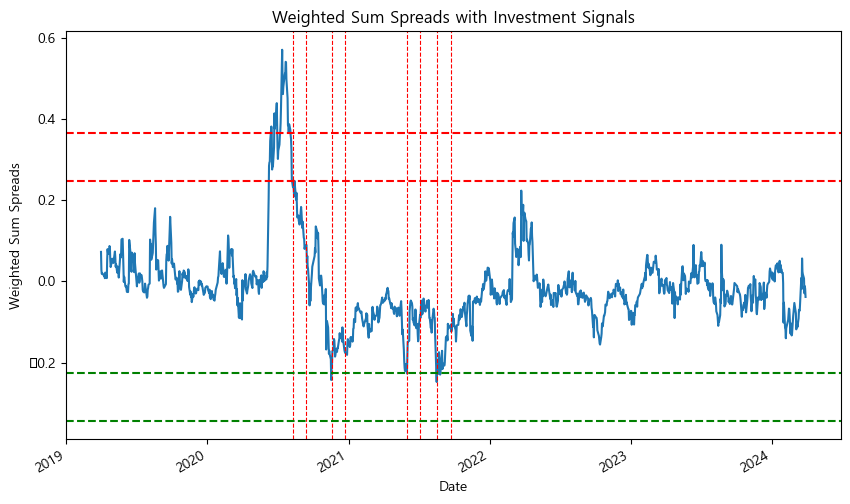

In [119]:
import matplotlib.pyplot as plt
def spread_graph(weighted_sum_spreads_series, signals_df):
    # 데이터 타입을 datetime으로 변환 (필요한 경우)
    signals_df['Date'] = pd.to_datetime(signals_df['Date'])
    weighted_sum_spreads_series.index = pd.to_datetime(weighted_sum_spreads_series.index)

    # weighted_sum_spreads_series 그래프 그리기
    plt.figure(figsize=(10, 6))
    weighted_sum_spreads_series.plot()

    # signals_df에서 중복 없이 모든 날짜 가져오기
    unique_dates = signals_df['Date'].drop_duplicates()

    # 각 날짜에 대해 수직선 그리기
    for date in unique_dates:
        plt.axvline(x=date, color='r', linestyle='--', linewidth=0.8)

    # 그래프에 타이틀 및 레이블 추가
    plt.title('Weighted Sum Spreads with Investment Signals')
    plt.xlabel('Date')
    plt.ylabel('Weighted Sum Spreads')
    plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Bound (2 Std Dev)')
    plt.axhline(y=upper_stop_bound, color='r', linestyle='--', label='Upper Bound (2 Std Dev)')
    plt.axhline(y=lower_bound, color='g', linestyle='--', label='Lower Bound (2 Std Dev)')
    plt.axhline(y=lowwer_stop_bound, color='g', linestyle='--', label='Lower Bound (2 Std Dev)')

    # 그래프 보여주기
    plt.show()

spread_graph(weighted_sum_spreads_series, signals_df)

In [184]:
signals_df

,Date,asset1,asset2,Investment Amount,Investment Type
0,2020-08-10,사조대림,한성기업,0.645293,Long
1,2020-08-10,사조대림,사조오양,0.325825,Long
2,2020-08-10,사조대림,동원수산,0.024489,Long
3,2020-08-10,사조대림,사조산업,0.004393,Long
4,2020-09-14,사조대림,한성기업,0.645293,Close
5,2020-09-14,사조대림,사조오양,0.325825,Close
6,2020-09-14,사조대림,동원수산,0.024489,Close
7,2020-09-14,사조대림,사조산업,0.004393,Close
8,2020-11-18,사조대림,한성기업,0.645293,Short
9,2020-11-18,사조대림,사조오양,0.325825,Short


In [228]:
# 초기 자본 설정
def get_position()
initial_capital = 100000000  # 1억

# 자본 변동을 추적할 DataFrame 준비
capital_df = pd.DataFrame(index=df.index)
capital_df['capital'] = initial_capital
signals_df['Date'] = signals_df['Date'].astype(str)
# 포지션을 추적할 딕셔너리
position_all = []

# 각 신호를 처리
for index, signal in signals_df.iterrows():
    date = signal['Date']
    asset1 = signal['asset1']
    asset2 = signal['asset2']
    investment_ratio = signal['Investment Amount']
    trade_type = signal['Investment Type']

    pair_index = [i for i, pairs in enumerate(selected_results) if pairs['columns'] == [asset1, asset2]][0]

    # 자본에서 투자할 금액 계산
    investment_amount = initial_capital * investment_ratio
    hedge_ratios = pd.Series(stat_all[pair_index][1][:, 0], index=pd.Series(spread_all[pair_index][0]).index)
    # 헷지 비율에 따른 투자 금액 계산

    if date in pd.Series(spread_all[pair_index][0]).index:
        hedge_ratio = 1
        amount_asset1 = investment_amount / (1 + hedge_ratio)
        amount_asset2 = amount_asset1 * hedge_ratio
    else:
        continue  # 해당 날짜에 헷지 비율 데이터가 없으면 거래를 진행하지 않음
    
    # 가격 정보
    price_asset1 = df.loc[date, asset1]
    price_asset2 = df.loc[date, asset2]
    
    # 거래 수량 계산
    quantity_asset1 = amount_asset1 / price_asset1
    quantity_asset2 = amount_asset2 / price_asset2
    positions = {}
    if trade_type == 'Long':
        # Asset1을 매수하고 Asset2를 매도
        positions[date] = {'asset1': (asset1, quantity_asset1, price_asset1,amount_asset1, 'buy'),
                           'asset2': (asset2, quantity_asset2, price_asset2,amount_asset2, 'sell')}
    elif trade_type == 'Short':
        # Asset1을 매도하고 Asset2를 매수
        positions[date] = {'asset1': (asset1, quantity_asset1, price_asset1, amount_asset1,'sell'),
                           'asset2': (asset2, quantity_asset2, price_asset2, amount_asset2,'buy')}
    elif trade_type == 'Close':
        positions[date] = {'asset1': (asset1, quantity_asset1, price_asset1,amount_asset1, 'close'),
                    'asset2': (asset2, quantity_asset2, price_asset2, amount_asset2,'close')}
    position_all.append(positions)


In [229]:
position_all

[{'2020-08-10': {'asset1': ('사조대림',
    2165.413590026275,
    14900,
    32264662.491391495,
    'buy'),
   'asset2': ('한성기업', 2061.6397758077633, 15650, 32264662.491391495, 'sell')}},
 {'2020-08-10': {'asset1': ('사조대림',
    1093.373098081947,
    14900,
    16291259.161421012,
    'buy'),
   'asset2': ('사조오양', 1930.243976471684, 8440, 16291259.161421012, 'sell')}},
 {'2020-08-10': {'asset1': ('사조대림',
    82.17774824068391,
    14900,
    1224448.4487861902,
    'buy'),
   'asset2': ('동원수산', 131.09726432400325, 9340, 1224448.4487861902, 'sell')}},
 {'2020-08-10': {'asset1': ('사조대림',
    14.740261637671743,
    14900,
    219629.89840130898,
    'buy'),
   'asset2': ('사조산업', 6.863434325040906, 32000, 219629.89840130898, 'sell')}},
 {'2020-09-14': {'asset1': ('사조대림',
    2187.4347451790845,
    14750,
    32264662.491391495,
    'close'),
   'asset2': ('한성기업',
    2288.2739355596805,
    14100,
    32264662.491391495,
    'close')}},
 {'2020-09-14': {'asset1': ('사조대림',
    1104.49214653

In [230]:
# 데이터프레임으로 변환하기 위한 빈 리스트 생성
data = []

# 각 항목을 반복하면서 데이터 추출 및 정리
for entry in position_all:
    for date, assets in entry.items():
        asset1_data = {
            'date': date,
            'asset_name': assets['asset1'][0],
            'quantity': assets['asset1'][1],
            'price': assets['asset1'][2],
            'amount': assets['asset1'][3],
            'action': assets['asset1'][4],
            'asset_type': 'asset1'
        }
        asset2_data = {
            'date': date,
            'asset_name': assets['asset2'][0],
            'quantity': assets['asset2'][1],
            'price': assets['asset2'][2],
            'amount': assets['asset2'][3],
            'action': assets['asset2'][4],
            'asset_type': 'asset2'
        }
        data.append(asset1_data)
        data.append(asset2_data)

# 데이터 리스트를 데이터프레임으로 변환
position_df = pd.DataFrame(data)
position_df

,date,asset_name,quantity,price,amount,action,asset_type
0,2020-08-10,사조대림,2165.413590,14900,3.226466e+07,buy,asset1
1,2020-08-10,한성기업,2061.639776,15650,3.226466e+07,sell,asset2
2,2020-08-10,사조대림,1093.373098,14900,1.629126e+07,buy,asset1
3,2020-08-10,사조오양,1930.243976,8440,1.629126e+07,sell,asset2
4,2020-08-10,사조대림,82.177748,14900,1.224448e+06,buy,asset1
...,...,...,...,...,...,...,...
59,2021-09-24,사조오양,1529.695696,10650,1.629126e+07,close,asset2
60,2021-09-24,사조대림,41.227220,29700,1.224448e+06,close,asset1
61,2021-09-24,동원수산,125.584456,9750,1.224448e+06,close,asset2
62,2021-09-24,사조대림,7.394946,29700,2.196299e+05,close,asset1


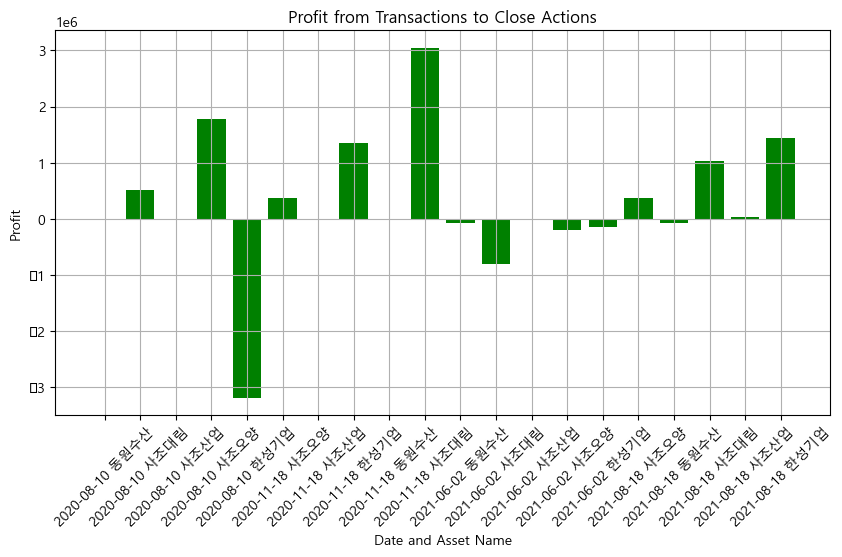

In [279]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 필터링
buy_short_df = position_df[(position_df['action'] == 'buy') | (position_df['action'] == 'sell')]
close_df = position_df[position_df['action'] == 'close']

# 'buy' 및 'short' 데이터에 대한 집계
buy_short_agg = buy_short_df.groupby(['date', 'asset_name', 'action']).agg({
    'quantity': 'sum',  # 총 수량 합계
    'price': 'mean'     # 평균 가격
}).reset_index()

close_agg = close_df.groupby(['date', 'asset_name']).agg({
    'quantity': 'sum',  # 총 수량 합계
    'price': 'mean'     # 평균 가격
}).reset_index()

# 날짜 데이터 타입을 보장하기 위해 변환
buy_short_agg['date'] = pd.to_datetime(buy_short_agg['date'])
close_agg['date'] = pd.to_datetime(close_agg['date'])

# 날짜에 따라 정렬 (merge_asof의 요구사항)
buy_short_agg.sort_values('date', inplace=True)
close_agg.sort_values('date', inplace=True)

# buy_short_agg의 각 행에 대해 date_close 컬럼이 date_trade 이후 가장 가까운 날짜를 갖는 행을 찾아 매칭
matched_df = pd.merge_asof(buy_short_agg, close_agg, on='date', by='asset_name', suffixes=('_trade', '_close'), direction='forward')

# 수익 계산
matched_df['profit'] = matched_df.apply(
    lambda row: row['quantity_trade'] * (row['price_trade'] - row['price_close']) if row['action'] == 'buy'
    else row['quantity_trade'] * (row['price_close'] - row['price_trade']),
    axis=1
)

# 수익 그래프 그리기
plt.figure(figsize=(10, 5))
plt.bar(matched_df['date'].astype(str) + ' ' + matched_df['asset_name'], matched_df['profit'], color='green')
plt.xticks(rotation=45)
plt.title('Profit from Transactions to Close Actions')
plt.xlabel('Date and Asset Name')
plt.ylabel('Profit')
plt.grid(True)
plt.show()


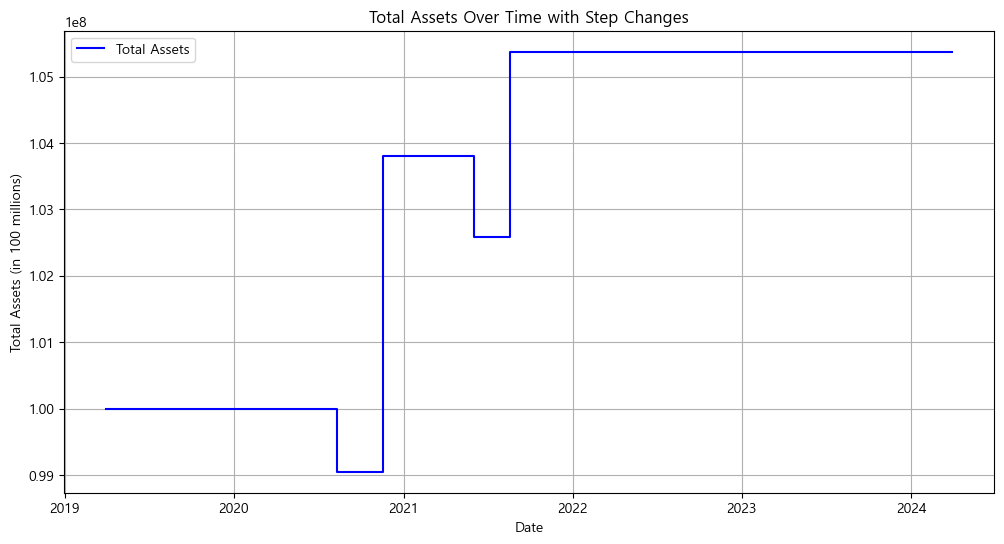

In [245]:
import pandas as pd
import matplotlib.pyplot as plt

# 날짜별로 수익 합산
daily_profit = matched_df.groupby('date')['profit'].sum().reset_index()

# 시작과 끝 날짜 추가
start_date = pd.DataFrame({'date': [pd.Timestamp('2019-04-01')], 'profit': [0]})
end_date = pd.DataFrame({'date': [pd.Timestamp('2024-03-29')], 'profit': [0]})

# 데이터프레임 병합
daily_profit = pd.concat([start_date, daily_profit, end_date]).reset_index(drop=True)

# 날짜별 누적 수익 계산
daily_profit['cumulative_profit'] = daily_profit['profit'].cumsum()

# 초기 자본금 설정
initial_capital = 100000000  # 1억 원

# 기초자산에 누적 수익 더하기
daily_profit['total_assets'] = initial_capital + daily_profit['cumulative_profit']

# 수익 그래프 그리기
plt.figure(figsize=(12, 6))
plt.step(daily_profit['date'], daily_profit['total_assets'], where='post', label='Total Assets', color='blue')
plt.title('Total Assets Over Time with Step Changes')
plt.xlabel('Date')
plt.ylabel('Total Assets (in 100 millions)')
plt.grid(True)
plt.legend()
plt.show()


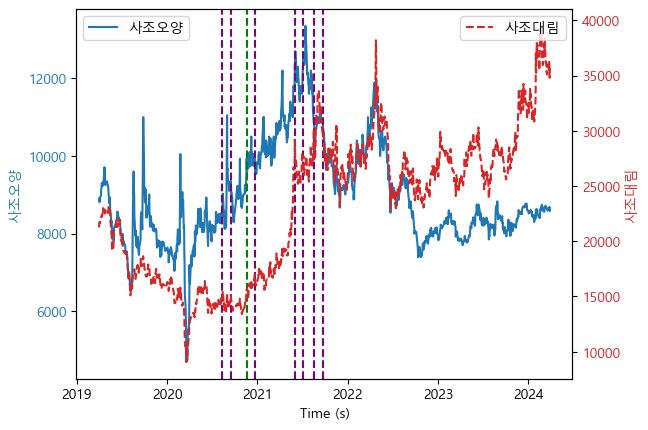

In [259]:
# 첫 번째 y축 설정
fig, ax1 = plt.subplots()
tickers = ['사조오양','사조대림']
color = 'tab:blue'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(tickers[0], color=color)
ax1.plot(df[tickers[0]], label=tickers[0], linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 레전드 추가
ax1.legend(loc='upper left')

# 두 번째 y축 설정
ax2 = ax1.twinx()  # 같은 x축을 공유하는 새로운 y축 생성
color = 'tab:red'
ax2.set_ylabel(tickers[1], color=color)
ax2.plot(df[tickers[1]], label=tickers[1], linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
# 두 번째 레전드 추가
ax2.legend(loc='upper right')
ax1.axvline(x=pd.Timestamp('2020-11-18'), color='green', linestyle='--', label='Important Date 1')
ax1.axvline(x=pd.Timestamp('2020-12-22'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2020-08-10'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2020-09-14'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2021-06-02'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2021-07-06'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2021-08-18'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2021-09-24'), color='purple', linestyle='--', label='Important Date 2')



In [275]:
np.log(df[tickers[0]])-stat_all[1][1][:,1]*np.log(df[tickers[1]])

Symbol Name
2019-04-01    0.897597
2019-04-02    0.853174
2019-04-03    0.838879
2019-04-04    0.839133
2019-04-05    0.843803
                ...   
2024-03-25    0.420160
2024-03-26    0.399540
2024-03-27    0.422520
2024-03-28    0.427367
2024-03-29    0.409819
Length: 1235, dtype: float64

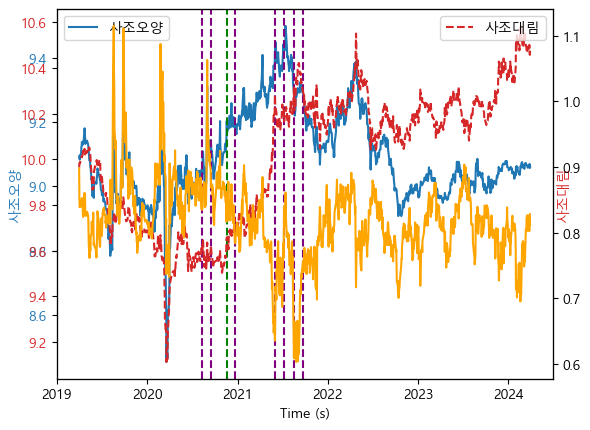

In [278]:
# 첫 번째 y축 설정
fig, ax1 = plt.subplots()
tickers = ['사조오양','사조대림']
color = 'tab:blue'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(tickers[0], color=color)
ax1.plot(np.log(df[tickers[0]]), label=tickers[0], linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 레전드 추가
ax1.legend(loc='upper left')

# 두 번째 y축 설정
ax2 = ax1.twinx()  # 같은 x축을 공유하는 새로운 y축 생성
color = 'tab:red'
ax2.set_ylabel(tickers[1], color=color)
ax2.plot(np.log(df[tickers[1]]), label=tickers[1], linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)
# 두 번째 레전드 추가
ax2.legend(loc='upper right')
ax1.axvline(x=pd.Timestamp('2020-11-18'), color='green', linestyle='--', label='Important Date 1')
ax1.axvline(x=pd.Timestamp('2020-12-22'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2020-08-10'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2020-09-14'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2021-06-02'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2021-07-06'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2021-08-18'), color='purple', linestyle='--', label='Important Date 2')
ax1.axvline(x=pd.Timestamp('2021-09-24'), color='purple', linestyle='--', label='Important Date 2')

ax3 = ax2.twinx()
ax3.plot(np.log(df[tickers[0]])-stat_all[1][1][:,0]*np.log(df[tickers[1]]), color = 'orange')


In [261]:
df

,사조대림,사조산업,사조오양,한성기업,동원수산
Symbol Name,,,,,
2019-04-01,21250,53100,8900,5650,8530
2019-04-02,21600,53000,8850,5640,8510
2019-04-03,21700,53500,8810,5680,8580
2019-04-04,21650,54800,8830,5730,8590
2019-04-05,21750,54700,8940,5760,8600
...,...,...,...,...,...
2024-03-25,35500,38600,8660,5790,6750
2024-03-26,36350,38650,8650,5620,6810
2024-03-27,35550,38550,8690,5610,6730
